In [4]:
from generateDataset import generateDataset
generateDataset()

🎯 Categorías encontradas: ['anartia_amathea', 'heliconius_doris', 'melanis_electron']

🐞 Categoría: anartia_amathea
📄 71 archivos copiados para entrenamiento
📄 20 archivos copiados para testing
📄 10 archivos copiados para validación

🐞 Categoría: heliconius_doris
📄 52 archivos copiados para entrenamiento
📄 15 archivos copiados para testing
📄 8 archivos copiados para validación

🐞 Categoría: melanis_electron
📄 52 archivos copiados para entrenamiento
📄 15 archivos copiados para testing
📄 8 archivos copiados para validación



Found 247 images belonging to 3 classes.
Found 244 images belonging to 3 classes.


/opt/miniconda3/envs/analitica/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5718 - loss: 0.9269

/opt/miniconda3/envs/analitica/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6437 - loss: 0.7827 - val_accuracy: 0.8156 - val_loss: 0.5383
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7571 - loss: 0.5630 - val_accuracy: 0.7623 - val_loss: 0.5447
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7854 - loss: 0.4673 - val_accuracy: 0.8648 - val_loss: 0.3693
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8178 - loss: 0.4292 - val_accuracy: 0.7992 - val_loss: 0.4879
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8097 - loss: 0.4247 - val_accuracy: 0.8525 - val_loss: 0.3615
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8462 - loss: 0.3581 - val_accuracy: 0.8238 - val_loss: 0.3553
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8664 - loss: 0.3354 - val_accuracy: 0.8730 - val_loss: 0.3111
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8745 - loss: 0.2567 - val_accuracy: 0.8975 - val_loss: 0.2587
Epoch 9/10
8/8 ━━━━

<Functional name=functional, built=True>


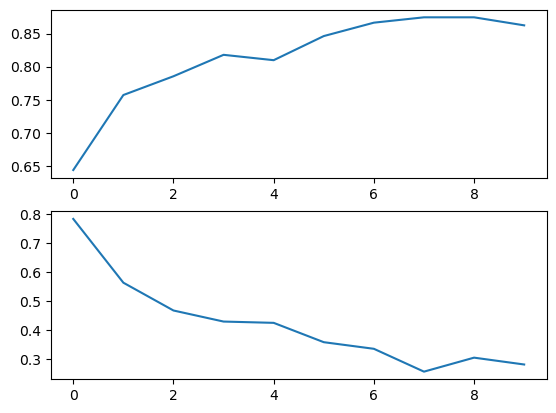

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

trainPath = "./dataset/train"
testPath = "./dataset/test"

#Generate more images
trainGenerator = ImageDataGenerator(rotation_range=15, width_shift_range=0.4, height_shift_range=0.1, brightness_range=(0,0.2)).flow_from_directory(trainPath, target_size=(320,320), batch_size=32)
testGenerator = ImageDataGenerator(rotation_range=15, width_shift_range=0.4, height_shift_range=0.1, brightness_range=(0,0.2)).flow_from_directory(testPath, target_size=(320,320), batch_size=32)

#Build model

baseModel = MobileNetV3Small(weights="imagenet", include_top=False)
x= baseModel.output
x= GlobalAveragePooling2D()(x) #1
x= Dense(512, activation="relu")(x) #2
x= Dense(256, activation="relu")(x) #3
x= Dense(128, activation="relu")(x) #4

predictionLayer = Dense(len(categories), activation="softmax")(x) #5

model = Model(inputs=baseModel.input, outputs=predictionLayer)

#Congelar todas las capas del modelo menos las 5 añadidas por nosotros
#Deja fijos los pesos de MobileNetV3 pero permite modificar los pesos de las capas que creamos
for layer in model.layers[:-5]:
    layer.trainable = False

#Compilar modelo
optimizer = Adam(learning_rate = 0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

#Entrenar modelo
modelTrainData = model.fit(trainGenerator, validation_data=testGenerator, epochs=10)

#Guardar modelo
saveModelPath = "./dataset/ModelV3.h5"
model.save(saveModelPath)

print(model)
plt.figure()
plt.subplot(211)
plt.plot(modelTrainData.history['accuracy'])
plt.subplot(212)
plt.plot(modelTrainData.history['loss'])

In [5]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

#Predict Image
def classify_image(IMG_PATH):
    x=[]
    img = Image.open(IMG_PATH)
    img.load()
    img = img.resize((320,320), Image.LANCZOS)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    return pred[0]

In [6]:
img_paths = [
    "./Insectos/melanis_electron/_8060558-melanissmithiaesmith-spixie-melanispixe4406.jpg",
    "./Insectos/heliconius_doris/Heliconius_doris_03.jpg",
    "./Insectos/anartia_amathea/Anartia amathea roeselia_mariposa174_NaturalezaMisiones.jpg",
    "./Insectos/heliconius_doris/Heleconius-doris-Yellow-form-TS-Peru_001-scaled-600x600.jpg",
    "./Insectos/anartia_amathea/Anartia_amathea_(5).jpg",
    "./Insectos/melanis_electron/50567919412_96679cea6a_b.jpg",
]

predictions = []
for path in img_paths:
    print(path)
    predictions.append(classify_image(path))

./Insectos/melanis_electron/_8060558-melanissmithiaesmith-spixie-melanispixe4406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
./Insectos/heliconius_doris/Heliconius_doris_03.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
./Insectos/anartia_amathea/Anartia amathea roeselia_mariposa174_NaturalezaMisiones.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
./Insectos/heliconius_doris/Heleconius-doris-Yellow-form-TS-Peru_001-scaled-600x600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
./Insectos/anartia_amathea/Anartia_amathea_(5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
./Insectos/melanis_electron/50567919412_96679cea6a_b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


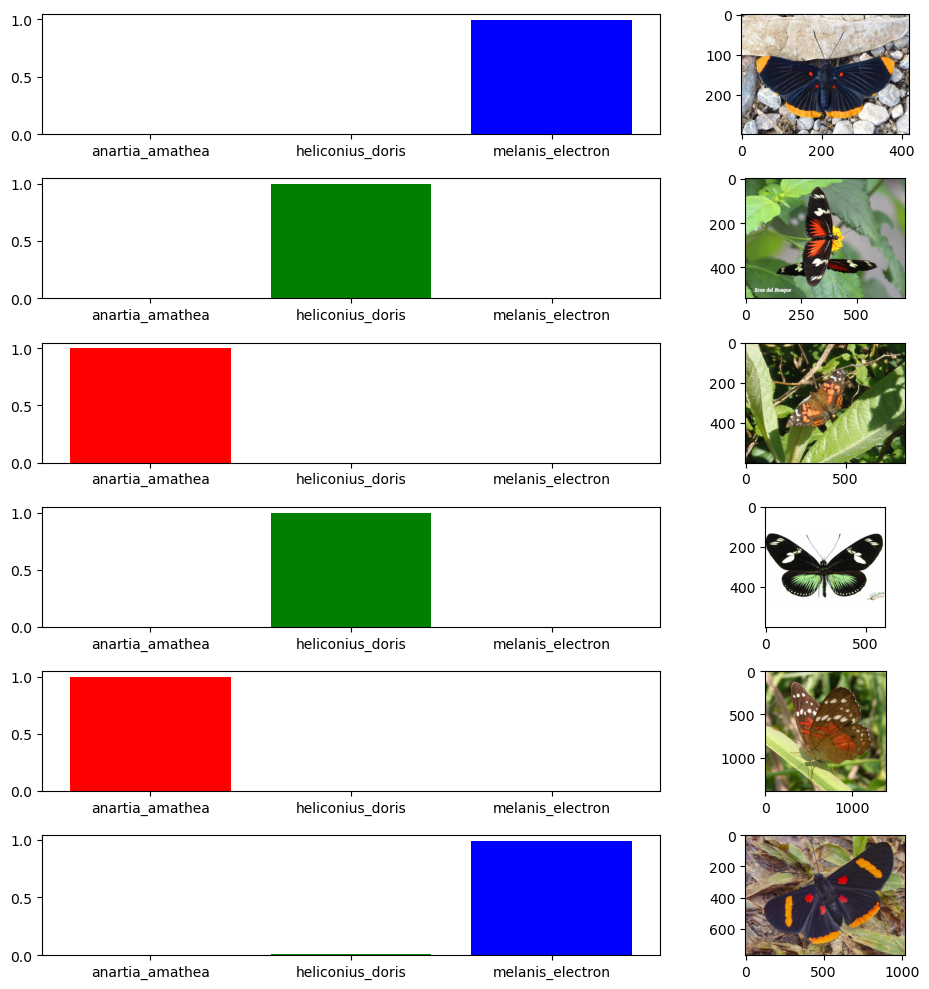

In [7]:
fig,axs = plt.subplots(len(predictions), 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})

plotIndex = 1
for i, pred in enumerate(predictions):
    plt.subplot(len(predictions), 2, plotIndex)
    plt.bar(categories, pred, color=['red', 'green', 'blue'])

    plt.subplot(len(predictions), 2, plotIndex+1)
    img = plt.imread(img_paths[i])
    plt.imshow(img)
    plotIndex += 2

fig.tight_layout()
plt.show()